### MLP

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load and Clean Data

In [2]:
df = pd.read_csv('recipe_review_data.csv')
print(df.head())

   Unnamed: 0  recipe_number  recipe_code         recipe_name  \
0           0              1        14299  Creamy White Chili   
1           1              1        14299  Creamy White Chili   
2           2              1        14299  Creamy White Chili   
3           3              1        14299  Creamy White Chili   
4           4              1        14299  Creamy White Chili   

                                        comment_id         user_id  \
0  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM  u_9iFLIhMa8QaG   
1  sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY  u_Lu6p25tmE77j   
2  sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP  u_s0LwgpZ8Jsqq   
3  sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC  u_fqrybAdYjgjG   
4  sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI  u_XXWKwVhKZD69   

    user_name  user_reputation  created_at  reply_count  thumbs_up  \
0     Jeri326                1  1665619889            0          0   
1     Mark467               50  1665277687      

In [3]:
# Drop missing values
df = df[['user_id', 'recipe_code', 'user_reputation', 'thumbs_up', 'thumbs_down', 'stars', 'text']].dropna()

# Encode user_id and recipe_code
user_encoder = LabelEncoder()
recipe_encoder = LabelEncoder()
df['user_id_enc'] = user_encoder.fit_transform(df['user_id'])
df['recipe_code_enc'] = recipe_encoder.fit_transform(df['recipe_code'])

# Fill empty reviews with empty string
df['text'] = df['text'].fillna("")

# text analysis set up
vectorizer = TfidfVectorizer(max_features=300)
text_features = vectorizer.fit_transform(df['text']).toarray()

# Normalize numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[['user_reputation', 'thumbs_up', 'thumbs_down']])

X_ids = df[['user_id_enc', 'recipe_code_enc']].values
X_all = np.hstack([X_ids, X_numeric, text_features])

# Set stars as float
y = df['stars'].astype(float).values

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

class RecipeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RecipeDataset(X_train, y_train)
test_dataset = RecipeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Model Setup and Training

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.Linear(32, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

input_dim = X_all.shape[1]
model = MLP(input_dim)

In [8]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 100
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            preds = model(batch_X)
            loss = criterion(preds, batch_y)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 1/100 - Train Loss: 20.8444, Test Loss: 19.9778
Epoch 2/100 - Train Loss: 20.3312, Test Loss: 20.2214
Epoch 3/100 - Train Loss: 19.9477, Test Loss: 20.5671
Epoch 4/100 - Train Loss: 20.5358, Test Loss: 20.5081
Epoch 5/100 - Train Loss: 20.3668, Test Loss: 19.9676
Epoch 6/100 - Train Loss: 20.4602, Test Loss: 20.6015
Epoch 7/100 - Train Loss: 20.6021, Test Loss: 20.5695
Epoch 8/100 - Train Loss: 20.5564, Test Loss: 20.5540
Epoch 9/100 - Train Loss: 20.5095, Test Loss: 20.5166
Epoch 10/100 - Train Loss: 20.4302, Test Loss: 20.3507
Epoch 11/100 - Train Loss: 20.3459, Test Loss: 20.4950
Epoch 12/100 - Train Loss: 20.4064, Test Loss: 20.4131
Epoch 13/100 - Train Loss: 20.0274, Test Loss: 20.1653
Epoch 14/100 - Train Loss: 19.5757, Test Loss: 19.7197
Epoch 15/100 - Train Loss: 19.0720, Test Loss: 19.3195
Epoch 16/100 - Train Loss: 9.3501, Test Loss: 3.3572
Epoch 17/100 - Train Loss: 3.1256, Test Loss: 2.8842
Epoch 18/100 - Train Loss: 2.9074, Test Loss: 2.4398
Epoch 19/100 - Train Loss

### Evaluation

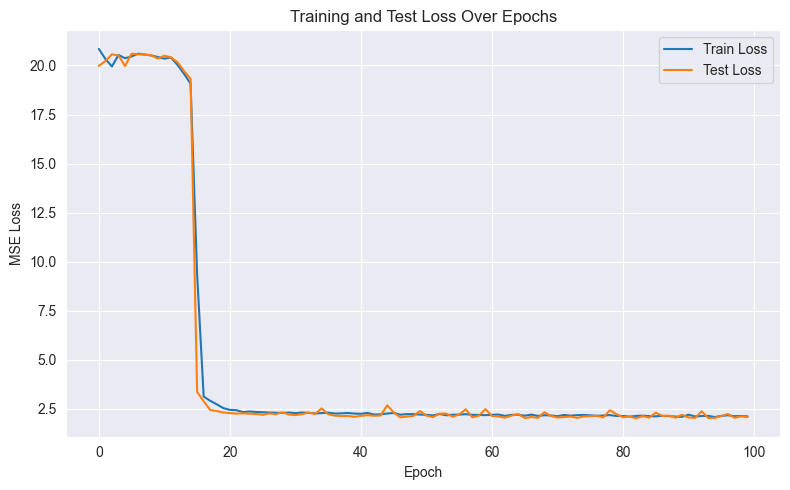

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()